# Лабораторная работа №4: Свойства оценок, полученных методом максимального правдоподобия 

**Цели и задачи л/р**: применить на практике метод максимального правдоподобия,
*оценить статистические свойства получаемых с их помощью статистических оценок
*параметров распределений. 

## Задание.
1. Применить метод максимального правдоподобия к равномерному закону
   распределения, чья плотность задана как $\varphi_r(x, a, b) = \begin{cases}\cfrac{1}{b-a}, x\in[a,b]\\0, x\not\in[a,b]\end{cases}$ 
   Пусть выборка значений соответствующей случайной величины $r$ задана как
   $x_1,x_2,x_3...x_n$. Построить оценки $a^*$ и $b^*$ для параметров $a$ и $b$.
2. Применить метод максимального правдоподобия к закону распределения Лапласа,
   чья плотность задана как $\varphi_r(x, c, \lambda)=\cfrac{\lambda}{2}\cdot e^{-\lambda|x-c|}$.
   Пусть выборка значений соответствующей случайной величины $r$ задана как
   $x_1,x_2,x_3...x_n$. Построить оценку $\lambda^*$ для параметра $\lambda$. 
3. Запрограммировать расчеты по полученным оценкам и построить график зависимости 
оценки их среднеквадратического отклонения (см. лаб. раб. 3) от размера выборки.

## Равномерное распределение

Функция МПП:

$$
L = \ln(\prod_{i=1}^k\varphi_r(x_i, a^*, b^*))= \ln\left(\left(\cfrac{1}{b^* - a^*}\right)^k\right) = -n\cdot\ln(b^* - a^*)
$$

Функция убывает с возрастанием разницы $b^* - a^*$, поэтому нужно её минимизировать.

Учитывая, что $a^* \leq x_{1}$ и $x_{n} \leq b^*$, минимум разницы будет достигаться, когда $a^* = x_{1} = \min x_i$ и $b^* = x_{n} = \max x_i$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from tqdm.contrib.concurrent import process_map
import scipy

np.random.seed(42)

/opt/pypy/lib/pypy3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_SIZES = [10, 30, 100, 300, 1000, 3000, 10000]
NUM_EXPERIMENTS = 1000
LAPLACE_TRUE_LAMBDA = 1.0
LAPLACE_TRUE_C = 0.0
UNIFORM_LOW = 0.0
UNIFORM_HIGH = 1.0

OUT_DIR = Path("lab-4")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def mle_uniform(sample):
    return np.min(sample), np.max(sample)

In [4]:
def experiment_uniform(args):
    n, i = args
    sample = np.random.uniform(UNIFORM_LOW, UNIFORM_HIGH, size=n)
    a_hat, b_hat = mle_uniform(sample)
    return (n, i, a_hat, b_hat)

In [5]:
args_uni = list(itertools.product(SAMPLE_SIZES, range(NUM_EXPERIMENTS)))
uni_rs = process_map(experiment_uniform, args_uni, chunksize=1)

100%|██████████| 7000/7000 [00:11<00:00, 621.63it/s] 


In [15]:
uni_flat = [r for r in uni_rs]
df_uni = pd.DataFrame(uni_flat, columns=("n", "iter", "a_est", "b_est"))
df_uni.to_csv(OUT_DIR / "uniform_mle_results.csv", index=False)

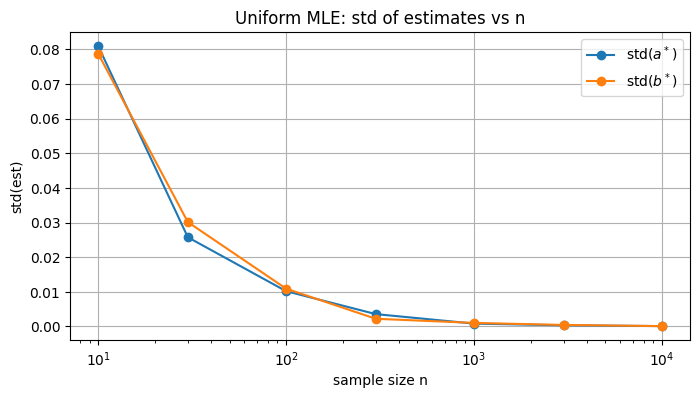

In [16]:
dfu = df_uni.groupby("n").agg({"a_est": "std", "b_est": "std"}).reset_index()
plt.figure(figsize=(8, 4))
plt.plot(dfu["n"], dfu["a_est"], marker="o", label="$\mathrm{std}(a^*)$")
plt.plot(dfu["n"], dfu["b_est"], marker="o", label="$\mathrm{std}(b^*)$")
plt.xscale("log")
plt.xlabel("sample size n")
plt.ylabel("std(est)")
plt.title("Uniform MLE: std of estimates vs n")
plt.legend()
plt.grid(True)
plt.show()

## Распределение Лапласа

Функция МПП:

$$
L = \ln(\prod_{i=1}^k\varphi_r(x_i, c^*, \lambda^*))= \ln\left(\left(\cfrac{\lambda^*}{2}\cdot e^{-\lambda^*\cdot|x_i-c^*|}\right)^k\right) = k\cdot\ln\lambda^* - k\cdot\ln 2 - \lambda^*\cdot \sum_{i=1}^k(|x_i-c^*|) 
$$

При фиксированном $\lambda$ максимум достигается при минимизации выражения $\sum_{i=1}^k(|x_i-c^*|)$, тогда $c^*$ -- в сущности точка, от которое минимальное расстояние до всех остальных точек, т.е. середина отредка $[x_{(1)}; x_{(n)}] = x_{0.5}$  -- медиана.
Более формально по индукции:

1.  База для случая с 
    - n = 1 -- очевидно, 
    - n = 2 -- любая из двух точек,
    - n = 3 -- средняя точка, т.к. очевидно, что точно между наибольшей и
      наименьшей, и разница с центральной должна быть минимальной.
2.  Индуктивный переход: пусть для n условие выполняется, тогда рассмотрим n + 2 точки.
    Аналогично, очевидно, что точка должна лежать между наибольшей и наименьшей, т.е. где-то среди n точек между ними. А для n (и даже n-1) условие выполняется.

Тогда для $\lambda$ при известном $c$ минимум можно найти дифференцируя:

$$
\frac{\partial L}{\partial \lambda} = \frac{k}{\lambda} - \sum_{i=1}^k |x_i-c| = 0
$$

$$
\lambda^* = \frac{k}{\sum_{i=1}^k |x_i-c^*|}
$$


In [17]:
def mle_laplace_c(sample):
    return np.median(sample)

def mle_laplace_lambda(sample, c_est):
    s = np.sum(np.abs(sample - c_est))
    if s == 0:
        return np.inf
    return len(sample) / s

In [18]:
def experiment_laplace(args):
    n, i = args
    scale = 1.0 / LAPLACE_TRUE_LAMBDA
    sample = scipy.stats.laplace.rvs(loc=LAPLACE_TRUE_C, scale=scale, size=n)
    c_est = mle_laplace_c(sample)
    lambda_est = mle_laplace_lambda(sample, c_est)
    return (n, i, c_est, lambda_est)

In [10]:
args_lap = list(itertools.product(SAMPLE_SIZES, range(NUM_EXPERIMENTS)))
lap_rs = process_map(experiment_laplace, args_lap, chunksize=1)

100%|██████████| 7000/7000 [00:44<00:00, 157.26it/s]


In [13]:
lap_flat = [r for r in lap_rs]
df_lap = pd.DataFrame(lap_flat, columns=("n", "iter", "c_est", "lambda_est"))
df_lap.to_csv(OUT_DIR / "laplace_mle_results.csv", index=False)

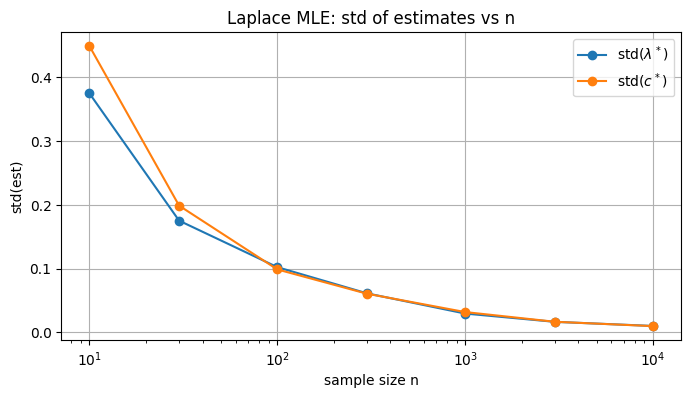

In [20]:
dfl = df_lap.groupby("n").agg({"lambda_est": "std", "c_est": "std"}).reset_index()
plt.figure(figsize=(8, 4))
plt.plot(dfl["n"], dfl["lambda_est"], marker="o", label="$\mathrm{std}(\lambda^*)$")
plt.plot(dfl["n"], dfl["c_est"], marker="o", label="$\mathrm{std}(c^*)$")
plt.xscale("log")
plt.xlabel("sample size n")
plt.ylabel("std(est)")
plt.title("Laplace MLE: std of estimates vs n")
plt.legend()
plt.grid(True)
plt.show()